In [1]:
import pandas as pd
import numpy as np
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft, data_adjust_scale, data_reshape_for_train
from util.data_generator_AE import DataGenerator
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn import metrics
from easydict import EasyDict

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4496097525678949853
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22723493888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11482212546136758187
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6"
]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [4]:
args = EasyDict({
    'dir_path' : r"C:\Users\VIP444\Documents\Anomaly-Dataset",
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 2,
    'data_scale_fit' : True,
    'data_scale_trans' : False,
    'batch_size' : 64,
    'split' : (0.9, 0.1),
    'is_cache' : True,
    'is_normalize' : False,
    'is_lstm' : True
})

In [5]:
train_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Train',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

validation_dataset = DataGenerator(
    dataset_path=args.dir_path,
    train_mode='Validation',
    batch_size=args.batch_size,
    split=args.split,
    is_train=args.is_train,
    is_cache=args.is_cache,
    is_normalize=args.is_normalize,
    is_lstm=args.is_lstm
)

In [ ]:
train_data_0, train_data_1, train_data_2, train_data_3, validation_data_0, validation_data_1, validation_data_2, validation_data_3 = load_data_raw(
    dir_path=args.dir_path, 
    is_normal=args.is_normal, 
    is_train=args.is_train, 
    stop_idx=args.stop_idx
    )

test_data_0, test_data_1, test_data_2, test_data_3 = load_data_raw(
    dir_path=args.dir_path,
    is_normal=False,
    is_train=False,
    stop_idx=args.stop_idx
)

display_data(train_data_0, validation_data_0, test_data_0)

In [ ]:
train_data_0_fft, train_data_1_fft, train_data_2_fft, train_data_3_fft = data_to_fft(train_data_0, train_data_1, train_data_2, train_data_3)
validation_data_0_fft, validation_data_1_fft, validation_data_2_fft, validation_data_3_fft = data_to_fft(validation_data_0, validation_data_1, validation_data_2, validation_data_3)
test_data_0_fft, test_data_1_fft, test_data_2_fft, test_data_3_fft = data_to_fft(test_data_0, test_data_1, test_data_2, test_data_3)

display_data(train_data_0_fft, validation_data_0_fft, test_data_0_fft)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('Scaler', MinMaxScaler())])

X_train_0 = data_adjust_scale(pipeline, train_data_0, args.data_scale_fit)
X_train_1 = data_adjust_scale(pipeline, train_data_1, args.data_scale_trans)
X_train_2 = data_adjust_scale(pipeline, train_data_2, args.data_scale_trans)
X_train_3 = data_adjust_scale(pipeline, train_data_3, args.data_scale_trans)

X_validation_0 = data_adjust_scale(pipeline, validation_data_0, args.data_scale_trans)
X_validation_1 = data_adjust_scale(pipeline, validation_data_1, args.data_scale_trans)
X_validation_2 = data_adjust_scale(pipeline, validation_data_2, args.data_scale_trans)
X_validation_3 = data_adjust_scale(pipeline, validation_data_3, args.data_scale_trans)

X_test_0 = data_adjust_scale(pipeline, test_data_0, args.data_scale_trans)
X_test_1 = data_adjust_scale(pipeline, test_data_1, args.data_scale_trans)
X_test_2 = data_adjust_scale(pipeline, test_data_2, args.data_scale_trans)
X_test_3 = data_adjust_scale(pipeline, test_data_3, args.data_scale_trans)

display_data(X_train_0, X_validation_0, X_test_0)

In [ ]:
X_train = concate_data((X_train_0, X_train_1, X_train_2, X_train_3), 1)
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), 1)
X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), 1)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

# X_train = data_reshape_for_train(X_train_0, X_train_1, X_train_2, X_train_3)
# X_validation = data_reshape_for_train(X_validation_0, X_validation_1, X_validation_2, X_validation_3)
# X_test = data_reshape_for_train(X_test_0, X_test_1, X_test_2, X_test_3)

# print(X_train.shape)
# print(X_validation.shape)
# print(X_test.shape)

In [6]:
from models.ae_LSTM import autoencoder_model
# from models.ae_Dense import autoencoder_model
from tensorflow.keras.optimizers import Adam

if args.is_lstm:
    input_shape = (1, 4)
else:
    input_shape = (4, )

model = autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              260   

In [7]:
epochs = 10

checkpoint_path = "model/checkpoint.pt"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1), 
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6,verbose=1,min_lr=1e-3 * 1e-1),
    CSVLogger('./train_log.csv', separator=',', append=True),
    ]

# history = model.fit(X_train, X_train, epochs=epochs, batch_size=args.batch_size, callbacks=callbacks, validation_data=(X_validation, X_validation)).history
history = model.fit(train_dataset, validation_data=(validation_dataset), epochs=epochs, batch_size=args.batch_size, callbacks=callbacks).history

model.load_weights(checkpoint_path)
model.save("model/model_concate.h5")

Epoch 1/10
177/177 [==============================] - 12s 52ms/step - loss: 0.0053 - acc: 0.2712 - val_loss: 0.0033 - val_acc: 0.1053

Epoch 00001: val_loss improved from inf to 0.00335, saving model to model\checkpoint.pt
Epoch 2/10
177/177 [==============================] - 9s 50ms/step - loss: 0.0056 - acc: 0.2655 - val_loss: 0.0035 - val_acc: 0.3684

Epoch 00002: val_loss did not improve from 0.00335
Epoch 3/10
177/177 [==============================] - 9s 50ms/step - loss: 0.0054 - acc: 0.2712 - val_loss: 0.0032 - val_acc: 0.3684

Epoch 00003: val_loss improved from 0.00335 to 0.00321, saving model to model\checkpoint.pt
Epoch 4/10
177/177 [==============================] - 9s 50ms/step - loss: 0.0055 - acc: 0.2938 - val_loss: 0.0031 - val_acc: 0.3684

Epoch 00004: val_loss improved from 0.00321 to 0.00308, saving model to model\checkpoint.pt
Epoch 5/10
177/177 [==============================] - 9s 50ms/step - loss: 0.0054 - acc: 0.2994 - val_loss: 0.0036 - val_acc: 0.1053

Epoch 

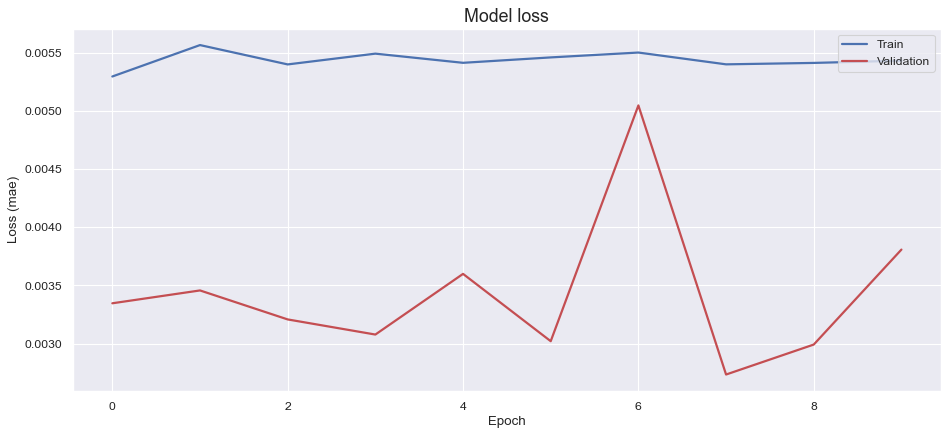

In [8]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

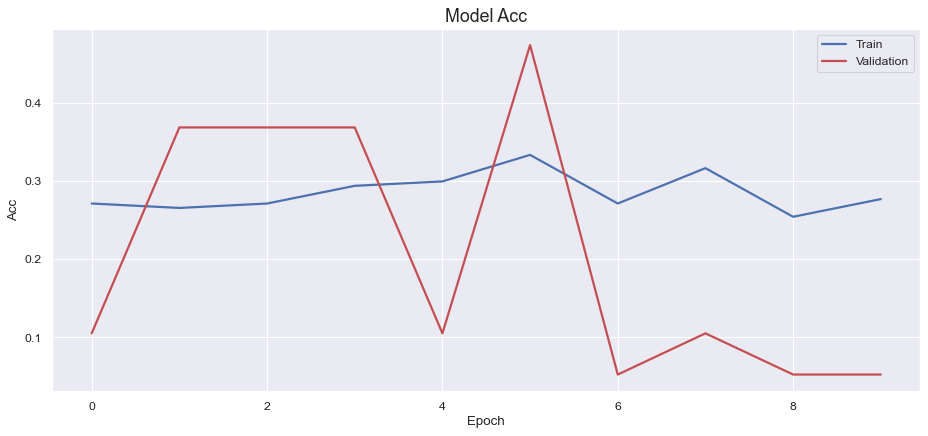

In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['acc'], 'b', label='Train', linewidth=2)
ax.plot(history['val_acc'], 'r', label='Validation', linewidth=2)
ax.set_title('Model Acc', fontsize=16)
ax.set_ylabel('Acc')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])

X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = tf.keras.models.load_model('model/model_concate.h5')
predictons_3d = model.predict(X_validation)
predictions = predictons_3d.reshape(predictons_3d.shape[0], predictons_3d.shape[2])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)

y_valid = np.ones(len(X_validation))

error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model/model_concate.h5')

X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[1]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./test_log.csv', sep=',')

In [ ]:
# X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_pred_val = model.predict(X_validation)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[1])
X_pred_val = pd.DataFrame(X_pred_val)

scored_val = pd.DataFrame()
Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1])
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis=1)
scored_val['Threshold'] = Threshold
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv('./validation_log.csv', sep=',')

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')